# Spectrogram Generative Adversarial Networks
## Initialisation and dataset preparation

First, let us import the required libraries.

In [181]:
import tensorflow as tf
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, stft, istft
import matplotlib.pyplot as plt
import librosa
import librosa.display
from misceallaneous import getWavFileAsNpArray, displaySpectrogram
from IPython.display import Audio

Then, let us include the dataset.

The dataset is made of two files: `clean/p1.wav`and `white/p1.wav` which are converted into arrays of `int32` and then split into segments of `samples_length`.

The goal of the CGAN here is to predict the clean sample, when fed with the white one.

In [267]:
samplerate = 12000
nperseg = 1024

clean = getWavFileAsNpArray("../dataset_2/clean/p1.wav")
white = getWavFileAsNpArray("../dataset_2/white/p1.wav")
clean = np.array(clean, dtype="float32")
white = np.array(white, dtype="float32")

clean_dataset = []
white_dataset = []

samples_length = nperseg*5

for i in range(0, clean.shape[0]-samples_length, samples_length):
    clean_dataset.append(clean[i:i+samples_length])
    white_dataset.append(white[i:i+samples_length])
clean_dataset = np.array(clean_dataset)
white_dataset = np.array(white_dataset)

In [322]:
spectrogram_clean_dataset = []
spectrogram_white_dataset = []
spectrogram_clean_dataset_imag = []
spectrogram_white_dataset_imag = []

for sample in clean_dataset:
    spectrogram_clean_dataset.append(np.abs(stft(sample)))
    spectrogram_clean_dataset_imag.append(np.imag(stft(sample)))
for sample in white_dataset:
    spectrogram_white_dataset.append(np.abs(stft(sample)))
    spectrogram_white_dataset_imag.append(np.imag(stft(sample)))

spectrogram_clean_dataset = np.array(spectrogram_clean_dataset)
spectrogram_white_dataset = np.array(spectrogram_white_dataset)

max_clean = np.max(spectrogram_clean_dataset)
min_clean = np.min(spectrogram_clean_dataset)
spectrogram_clean_dataset = (spectrogram_clean_dataset-min_clean)/max_clean

max_white = np.max(spectrogram_white_dataset)
min_white = np.min(spectrogram_white_dataset)
spectrogram_white_dataset = (spectrogram_white_dataset-min_white)/max_white

<ipython-input-322-321540893620>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  spectrogram_clean_dataset.append(np.abs(np.array(stft(sample))))
<ipython-input-322-321540893620>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  spectrogram_clean_dataset_imag.append(np.imag(np.array(stft(sample))))
<ipython-input-322-321540893620>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must speci

ValueError: operands could not be broadcast together with shapes (129,) (41,) 

In [313]:
data_shape = (spectrogram_white_dataset.shape)

In [314]:
print("Data shape:", data_shape)
print("Dataset shape:", spectrogram_white_dataset.shape)

Data shape: (2131, 378, 28)
Dataset shape: (2131, 378, 28)


In [288]:
print(np.min(np.abs(spectrogram_white_dataset)), np.max(np.abs(spectrogram_white_dataset)))

0.0 1.0


In [323]:
# Semble pas juste sur la normalisation
def view_input(dataset, i=0):
    pred = ((dataset[i])*max_clean)+min_clean
    S_dB = librosa.amplitude_to_db(pred, ref=np.max)
    librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=samplerate)
    plt.show()
    
def view_output(dataset, g, p, i=0):
    y = np.reshape(dataset[i], (-1, dataset.shape[1], dataset.shape[2]))
    array = g.predict(y)
    pred = ((array[0, :, :])*max_clean)+min_clean
    S_dB = librosa.amplitude_to_db(pred, ref=np.max)
    librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=samplerate)
    #plt.show()
    plt.savefig(str(p)+".png", format='png')
    
def hear_input(dataset, i=0):
    pred = ((dataset[i, :, :])*max_clean)+min_clean
    output = librosa.istft(((pred+min_clean)*max_clean)+np.imag(dataset[i]))
    return output
    
def hear_output(dataset, gan, i=0):
    y = np.reshape(dataset[i], (-1, dataset.shape[1], dataset.shape[2]))
    array = g.predict(y)
    pred = ((array[0, :, :])*max_clean)+min_clean
    output = librosa.istft(((pred+min_clean)*max_clean)+np.imag(dataset[i]))
    return output
    
view_input(spectrogram_clean_dataset)
view_input(spectrogram_white_dataset)

ValueError: operands could not be broadcast together with shapes (129,) (41,) 

## Generator
The generator itself is a Convolutionnal Autoencoder.

Its input size and output size are both the size of the stft array.

In [291]:
def generator(sizes):
    inputs = tf.keras.Input(shape=(sizes[1], sizes[2]))
    x = tf.keras.layers.Dropout(0.3)(inputs)
    y = tf.keras.layers.Dense(22, activation="relu")(x)
    x1 = tf.keras.layers.Permute((2, 1))(y)
    x2 = tf.keras.layers.Convolution1D(64, kernel_size=(3), activation="tanh", padding="same")(x1)
    x3 = tf.keras.layers.Convolution1D(32, kernel_size=(3), activation="tanh", padding="same")(x2)
    x4 = tf.keras.layers.Conv1DTranspose(64, kernel_size=(3), activation="tanh", padding="same")(x3)
    x5 = tf.keras.layers.Conv1DTranspose(256, kernel_size=(3), activation="tanh", padding="same")(x4)
    x6 = tf.keras.layers.Permute((2, 1))(x5)
    y1 = tf.keras.layers.Dense(sizes[2], activation="relu")(x6)
    a = tf.keras.layers.Add()([x, y1])
    outputs = tf.keras.layers.Dense(sizes[2], activation='tanh')(a)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="autoencoder")
    model.summary()
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    return model
g = generator(spectrogram_white_dataset.shape)

Model: "autoencoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_49 (InputLayer)           [(None, 256, 41)]    0                                            
__________________________________________________________________________________________________
dropout_52 (Dropout)            (None, 256, 41)      0           input_49[0][0]                   
__________________________________________________________________________________________________
dense_83 (Dense)                (None, 256, 22)      924         dropout_52[0][0]                 
__________________________________________________________________________________________________
permute_40 (Permute)            (None, 22, 256)      0           dense_83[0][0]                   
________________________________________________________________________________________

In [292]:
def evaluate_generator(g, inputs, outputs, size=100):
    res = 0
    s = min(size, inputs.shape[0])
    for i in range(s):
        error = (g.predict(np.reshape(inputs[i], (-1, inputs[i].shape[0], inputs[i].shape[1])))-outputs[i])**2
        res += np.sum(error)
    return res/(s)

In [293]:
def train_on_batch(d, i, o, validation_split=0, batch_size=16, verbose=True):
    history = d.fit(i, o, batch_size=batch_size, validation_split=validation_split, verbose=verbose)
    return np.mean(history.history['accuracy'])

In [294]:
p = 0

533/533 [==============================] - 19s 34ms/step - loss: 4.4827e-04 - accuracy: 0.0957
0.6596740715764463
533/533 [==============================] - 17s 31ms/step - loss: 7.2156e-05 - accuracy: 0.2000
0.3466978357359767
533/533 [==============================] - 14s 26ms/step - loss: 4.4283e-05 - accuracy: 0.2362
0.27771882922388613
533/533 [==============================] - 12s 22ms/step - loss: 3.6252e-05 - accuracy: 0.2513
0.23367382703348993
533/533 [==============================] - 17s 32ms/step - loss: 3.1881e-05 - accuracy: 0.2599
0.2126524124853313
533/533 [==============================] - 12s 22ms/step - loss: 2.9252e-05 - accuracy: 0.2645
0.19571011689025908
533/533 [==============================] - 16s 30ms/step - loss: 2.7240e-05 - accuracy: 0.2714
0.19202308072708546
533/533 [==============================] - 17s 32ms/step - loss: 2.6101e-05 - accuracy: 0.2712
0.19907391213346273
533/533 [==============================] - 14s 26ms/step - loss: 2.4767e-05 - accur

KeyboardInterrupt: 

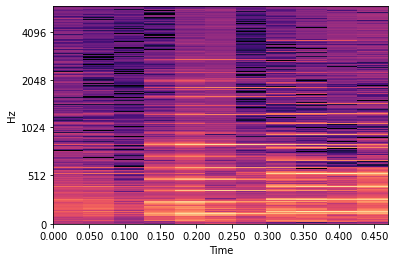

In [278]:
g_accuracy = 0
while p < 200:
    g_accuracy = train_on_batch(g, spectrogram_white_dataset, spectrogram_clean_dataset, batch_size=4, verbose=True)
    err = evaluate_generator(g, spectrogram_white_dataset, spectrogram_clean_dataset, 100)
    print(err)
    view_output(spectrogram_white_dataset, g, p)
    p += 1

In [279]:
res = []
for i in range(10):
    res.append(hear_output(spectrogram_white_dataset, g, i))
audio = np.concatenate(res)
Audio(audio, rate=samplerate)

In [315]:
res = []
for i in range(10):
    res.append(hear_input(spectrogram_clean_dataset, i))
audio = np.concatenate(res)
Audio(audio, rate=samplerate)